# Spinning Circles Fourier Visualization in Python/Matplotlib
### By Alex Miller ([@alexpmil](https://twitter.com/alexpmil))

This notebook goes through the process of how to construct an a Fourier approximation of a simple image and then animate the approximation using matplotlib.

In [2]:
# Main importrs/Initialization
%matplotlib inline
import matplotlib
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import HTML
import pylab as pl
import numpy as np
from PIL import Image, ImageEnhance
import requests
from io import BytesIO
from copy import deepcopy
from scipy.spatial import distance
from scipy.interpolate import UnivariateSpline
from copy import deepcopy

# Default figure size in notebook
matplotlib.rcParams['figure.figsize'] = (6,6)

## Step 1: Image Manipulation
The `ImageObject` class below provides functions for extracting a path of coordinates from a simplistic monochrome image. This path forms the basis of the parametric functions that I will be approximating using Fourier series.

In [3]:
class ImageObject:
    def __init__(self, url):
        self.url = url
        response = requests.get(url)
        self.img = Image.open(BytesIO(response.content))
        self.og_size = self.img.size
    
    def show(self):
        imshow(np.asarray(self.img))

    def monochrome(self, scale=3, threshold=200):
        
        # convert image to monochrome
        image = self.img.convert('L')
        image_array = np.array(image)
        
        # Binarize a numpy array using threshold as cutoff
        for i in range(len(image_array)):
            for j in range(len(image_array[0])):
                if image_array[i][j] > threshold:
                    image_array[i][j] = 255
                else:
                    image_array[i][j] = 0
        
        image = Image.fromarray(image_array)
        
        # scale image down to reduce number of non-zero pixels
        img_sm = image.resize(tuple([int(v/scale) for v in image.size]),Image.ANTIALIAS)
        
        # convert image to black and white
        img_bw = img_sm.convert(mode='1', dither=2) 
        self.bw_img = img_bw
        self.pixels = (1 - np.asarray(img_bw).astype(int))
        self.pixels_flat = np.reshape(self.pixels, self.pixels.size)
    
    def show_bw(self):
        print("Dimensions: {}".format(self.bw_img.size))
        print("Num. pixels: {}".format(self.pixels.sum()))
        imshow(np.asarray(self.bw_img))
    
    def get_tour(self, starting_point="random", plot=True):
        # Get greedy tour through pixels
        
        absolute_index = np.where(self.pixels_flat > 0)[0] # positions of non-zero pixels
        relative_index = np.array(range(1, len(absolute_index)+1 ))
        
        # Replace each non-zero pixel in the array with its number
        # i.e., the 10th non-zero pixel will have 10 in its place
        flat_img_mod = deepcopy(self.pixels_flat)
        for rel, pix in enumerate(absolute_index):
            flat_img_mod[pix] = rel+1
        
        # Get coordiantes for each non-zero pixel
        img_idx = np.reshape(flat_img_mod, self.pixels.shape)
        self.coord_list = []
        for p1 in relative_index:
            p1_coords = tuple([int(c) for c in np.where(img_idx==p1)])
            self.coord_list.append(list(p1_coords))
        
        # Calcualte distance between each pair of coords
        dist_mat = distance.cdist(self.coord_list, self.coord_list, 'euclidean')

        # Initialize search space with nearest neighbor tour
        cities = self.coord_list
        num_cities = len(cities)
        if starting_point=="random":
            start = int(np.random.choice(range(num_cities),size=1))
        else:
            assert starting_point < num_cities
            start = starting_point
        tour = [start]
        active_city = start
        for step in range(0, num_cities):
            dist_row = deepcopy(dist_mat[active_city,:])
            for done in tour:
                dist_row[done] = np.inf
            nearest_neighbor = np.argmin(dist_row)
            if nearest_neighbor not in tour:
                tour.append(nearest_neighbor)
            active_city = nearest_neighbor

        y_tour = -np.array([cities[tour[i % num_cities]] for i in range(num_cities+1) ])[:,0]
        y_tour = y_tour - y_tour[0]#- min(y_tour)
        x_tour = np.array([cities[tour[i % num_cities]] for i in range(num_cities+1) ])[:,1]    
        x_tour = x_tour - x_tour[0]#- min(x_tour)

        # Circle tour back to beginning
        np.append(x_tour, x_tour[0])
        np.append(y_tour, y_tour[0])
        num_cities = num_cities + 1
    
        self.x_tour = x_tour
        self.y_tour = y_tour
        self.num_pixels = num_cities
        
        if plot:
            plt.plot(self.x_tour, self.y_tour)
            
    def get_splines(self, degree=1, plot=True):
        # Convert tours into parametric spline curves
        
        x_spl = UnivariateSpline(list(range(0,self.num_pixels)), self.x_tour, k=degree)
        y_spl = UnivariateSpline(list(range(0,self.num_pixels)), self.y_tour, k=degree)
        
        self.x_spl = x_spl
        self.y_spl = y_spl
        
        if plot:
            p = pl.plot(*zip(*[(x_spl(v), y_spl(v)) for v in np.linspace(0, self.num_pixels-1, 1000)]))

            
    def plot_parametric(self, num_points=1000):
        # num_points = number of points at which to sample the curves
        t_vals, x_vals = zip(*[
            (v, self.x_spl(v)) for v in np.linspace(0, self.num_pixels, num_points)
        ])
        x_vals = np.array(x_vals)
        y_vals = np.array([self.y_spl(v) for v in np.linspace(0, self.num_pixels, num_points)])
        t_vals = np.array(t_vals)

        plt.plot(t_vals, x_vals)
        plt.plot(t_vals, y_vals)

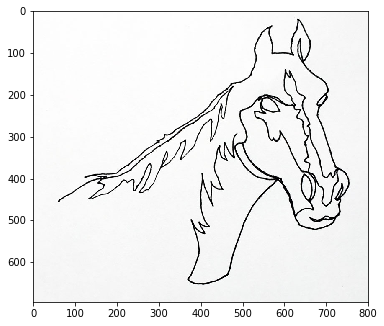

In [4]:
# Initialize an ImageObject instance and view the Image
# Obviously, it helps to have a simple image with only 2 colors and 
# close to a single path
url = "http://thevirtualinstructor.com/images/continuouslinedrawinghorse.jpg"
horse = ImageObject(url)
horse.show()

Dimensions: (266, 231)
Num. pixels: 2981


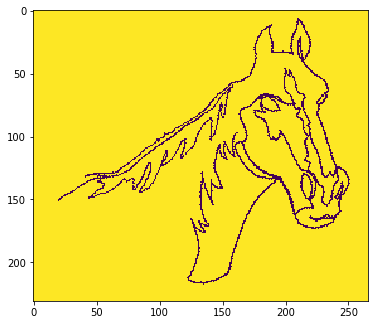

In [5]:
# Scale the image down by a factor of 3 
# and binarize the pixels using a threshold of
# 200 (out of the 0-255 scale) as my cutoff
horse.monochrome(scale=3, threshold=200)
horse.show_bw()

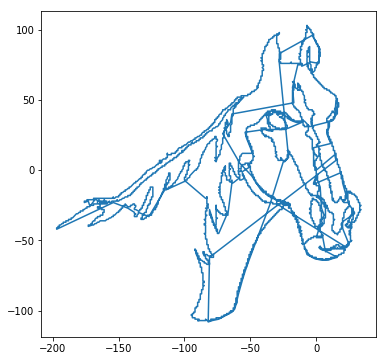

In [6]:
# Get a tour through the coordinate space of pixels
# Experiment with various starting points until the
# final result looks reasonably simple without too
# many jumps
horse.get_tour(starting_point=1300)

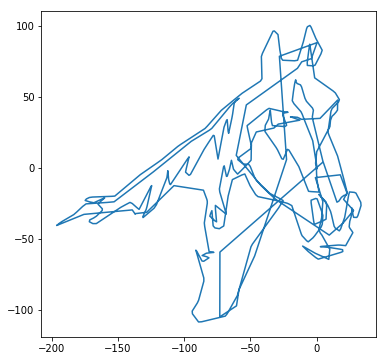

In [7]:
# Get parametric spline functions of the tour
horse.get_splines()

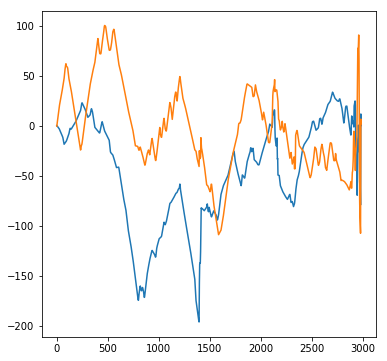

In [8]:
# Plot the x/y splines as parametric functions
# of a separate varaible, t
horse.plot_parametric()

## Step 2: Calculate Fourier Approximations

In [9]:
class FourierTransform:
    """Calculate the complex Fourier coefficients for a given function
    """
    def __init__(self,
            fxn,  # Function to be transformed (as Python function object)
             # Note: y is parameterized by its own index
             # 13th value in array = value of function at t=12
            rnge, # (.,.) tuple of range at which to evaluate fxn
            N=500,  # Number of coefficients to calculate
            period=None,  # If different than full length of function
            num_points=1000, # Number of points at which to evalute function
            num_circles=50 # This is needed to calculate proper offsets
        ):
        
        self.num_circles = num_circles
        
        t_vals, y = zip(*[(v, fxn(v)) for v in np.linspace(rnge[0], rnge[1]-1, num_points)])
        t_vals = np.array(t_vals)        
        self.t_vals = t_vals
        
        
        # Save the original coords when plotting
        y = np.array(y)
        y = y - y[0]
        self.fxn_vals = np.array(deepcopy(y))
        
        # Spline function doesn't make endpoints exactly equal
        # This sets the first and last points to their average
        endpoint = np.mean([y[0], y[-1]])
        y[0] = endpoint
        y[-1] = endpoint
        
        # Transform works best around edges when function starts at zero
        # (Can't figure out how to avoid Gibbs-type phenomenon when 
        #  intercept !=0 )
        y = y - y[0]
        
        self.N = N
        if period==None:
            period = rnge[1]
        self.period = period
            
        def cn(n):
            c = y*np.exp(-1j*2*n*np.pi*t_vals/period)
            return(c.sum()/c.size)

        coefs = [cn(i) for i in range(1,N+1)]
        self.coefs = coefs
        self.real_coefs = [c.real for c in self.coefs]
        self.imag_coefs = [c.imag for c in self.coefs]
        
        self.amplitudes = np.absolute(self.coefs)
        self.phases = np.angle(self.coefs)
        
        
        def f(x, degree=N):
            # Evaluate the function y at time t using Fourier approximiation of degree N
            f = np.array([2*coefs[i-1]*np.exp(1j*2*i*np.pi*x/period) for i in range(1,degree+1)])
            return(f.sum())
        
        # Evaluate function at all specified points in t domain
        fourier_approximation = np.array([f(t, degree=N).real for t in t_vals])
        circles_approximation = np.array([f(t, degree=self.num_circles).real for t in t_vals])
        
        # Set intercept to same as original function
        #fourier_approximation = fourier_approximation - fourier_approximation[0] + self.original_offset 
        
        # Adjust intercept to minimize distance between entire function, 
        # rather than just the intercepts. Gibbs-type phenomenon causes
        # perturbations near endpoints of interval
        fourier_approximation = fourier_approximation - (fourier_approximation - self.fxn_vals).mean()
        
        circles_approximation = circles_approximation - (circles_approximation - self.fxn_vals).mean()
        self.circles_approximation = circles_approximation
        
        # Origin offset
        self.origin_offset = fourier_approximation[0] - self.fxn_vals[0]
        
        # Circles offset
        self.circles_approximation_offset = circles_approximation[0] - self.fxn_vals[0]
        
        # Set intercept to same as original function
        self.fourier_approximation = fourier_approximation
        
        
        

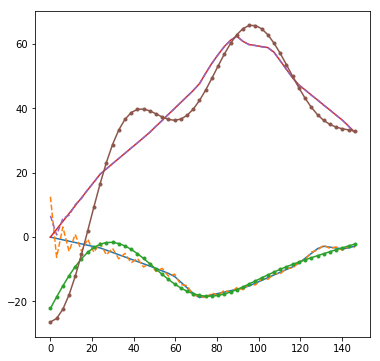

In [11]:
# Calculate Fourier approximations; initialize NC equal to the
# number of circles the final animation will have to get an 
# accurate view of how well the image will be approximated
NC = 50
xFT = FourierTransform(horse.x_spl, (0, horse.num_pixels), num_circles=NC)
yFT = FourierTransform(horse.y_spl, (0, horse.num_pixels), num_circles=NC)

# Plot the full approximation and the NC-degree 
# approximation for t from 1-R
R = 50
plt.plot(xFT.t_vals[0:R], xFT.fxn_vals[0:R])
plt.plot(xFT.t_vals[0:R], xFT.fourier_approximation[0:R], "--")
plt.plot(xFT.t_vals[0:R], xFT.circles_approximation[0:R], ".-")

plt.plot(yFT.t_vals[0:R], yFT.fxn_vals[0:R])
plt.plot(yFT.t_vals[0:R], yFT.fourier_approximation[0:R], "--")
plt.plot(yFT.t_vals[0:R], yFT.circles_approximation[0:R], ".-")

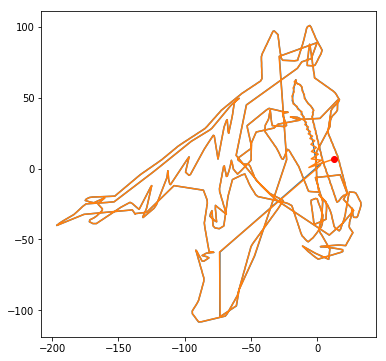

In [12]:
# Visualize the approximation as 2D image
plt.plot(xFT.fxn_vals, yFT.fxn_vals)
plt.plot(xFT.fourier_approximation, yFT.fourier_approximation)
plt.plot(xFT.fourier_approximation[0], yFT.fourier_approximation[0], 'o', color='red')

## Step 3: Calculate positions of each circle throughout cycle

In [13]:
class ComplexCircles:
    """Complex Circles Class:
        Tracks radii and centers of circles implied by 
        Fourier decomposition of given FourierTransform object
    """
    def __init__(self,
                 FT, # FourierTransform object
                 num_circles=20, # Number of circles to keep track of
                 t_init=0, # Initial time state of object
                 origin=(0, 0) # Center of the first circle
        ):
        self.FT = FT
        self.t_init = t_init
        if num_circles > FT.N:
            raise Exception("num_circles exceeds the degree of the given Fourier series.")
        self.num_circles = num_circles
        self.origin = origin
        self.origin_x = origin[0]
        self.origin_y = origin[1]
        self.t_elapsed = 0
        self.steps_elapsed = 0
        self.t_current = self.t_init
        self.t_index_current = 0
        self.true_fxn_val_current = self.FT.fxn_vals[t_init]
        self.fourier_approx_val_current = self.FT.fourier_approximation[t_init]
        
        self.Xs = [] # Track the coords of the center of the last circle
        self.Ys = [] # for each value of t 
        
        self.As = FT.amplitudes[0:num_circles] # Amplitude of each frequency/circle
        self.Zs = FT.phases[0:num_circles] # Phase of each frequency/cirlce
    
    def circle_positions(self, transpose=False):
        """compute the current radii and centers of each circle at the current value of t"""
        
        num_circles = self.num_circles
        t = self.t_current
        
        running_x_offset = deepcopy(self.origin_x)
        running_y_offset = deepcopy(self.origin_y)

        # There will be 1 more center than radius;
        # Use this to plot the last point on the last circle
        # Stored in final_x, final_y below
        radii = []
        x_centers = [deepcopy(self.origin_x)]
        y_centers = [deepcopy(self.origin_y)]
        
        for i in range(0,num_circles):
            freq = i+1 # Corresponding frequency for given circle/coefficient
            a = self.As[i] # Magnitude (i.e., amplitude) of complex coefficient
            z = self.Zs[i] # Argument (i.e., phase) of complex coefficient

            radius = 2*a
            radii.append(radius)
            
            running_x_offset += 2*a*np.cos(t*2*np.pi*freq/self.FT.period + z)
            running_y_offset += 2*a*np.sin(t*2*np.pi*freq/self.FT.period + z)
            
            if i < num_circles-1:
                x_centers.append(running_x_offset)
                y_centers.append(running_y_offset)
            
        if t==0:
            self.circles_offset = running_x_offset
        radii = np.array(radii)
        x_centers = np.array(x_centers) - self.circles_offset + self.FT.origin_offset
        y_centers = np.array(y_centers)
        
        x_final = running_x_offset - self.circles_offset + self.FT.origin_offset
        y_final = running_y_offset
        
        self.Xs.append(x_final)
        self.Ys.append(y_final)
        
        if transpose:
            return(radii, -y_centers, x_centers, -y_final, x_final)
        return(radii, x_centers, y_centers, x_final, y_final)
    
    
    def get_circles(self, transpose=False):
        return(self.circle_positions(transpose=transpose))
    
    def step(self, dt=1):
        # dt = how many times to increment t_vals array for each step
        self.steps_elapsed += 1
        next_index = dt*self.steps_elapsed 
        if next_index > len(self.FT.t_vals)-1:
            print("Max t-value reached")
            self.steps_elapsed -= 1
        else:
            self.t_current = self.FT.t_vals[next_index]
            self.t_elapsed = self.t_current - self.t_init
            self.t_index_current = next_index
            self.true_fxn_val_current = self.FT.fxn_vals[next_index]
            self.fourier_approx_val_current = self.FT.fourier_approximation[next_index]

In [ ]:
num_circles = 50
xFT = FourierTransform(horse.x_spl, (0, horse.num_pixels), N=num_circles)
xCircles = ComplexCircles(xFT, num_circles=num_circles, origin=(0,0))
for s in range(0,len(xFT.t_vals)):
    xCircles.get_circles()
    xCircles.step() 

R = 100
plt.plot(xFT.t_vals[0:R], xFT.fxn_vals[0:R])
plt.plot(xFT.t_vals[0:R], xCircles.Xs[0:R], "--")# (xCircles.Xs - (xCircles.Xs - xFT.fxn_vals).mean())[0:R], "--")
plt.plot(xFT.t_vals[0:R], xFT.fourier_approximation[0:R])

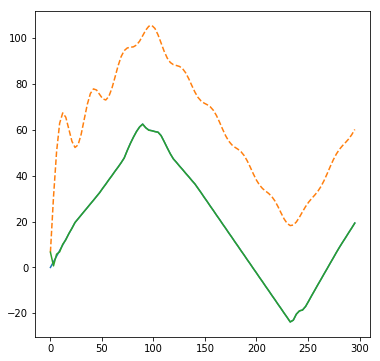

In [16]:
R = 100
yCircles = ComplexCircles(yFT, num_circles=100)
for s in range(0,R):
    yCircles.get_circles()
    yCircles.step() 

plt.plot(yFT.t_vals[0:R], yFT.fxn_vals[0:R])
plt.plot(yFT.t_vals[0:R], yCircles.Xs[0:R], "--")# (xCircles.Xs - (xCircles.Xs - xFT.fxn_vals).mean())[0:R], "--")
plt.plot(yFT.t_vals[0:R], yFT.fourier_approximation[0:R])

## Step 4: Animate the circles!

In [18]:
x_spl = horse.x_spl
y_spl = horse.y_spl
num_pixels = horse.num_pixels

# Number of circles to draw in animation
num_circles = 100

anim_length = 20 # in seconds
fps = 24 # frames per second
num_frames = anim_length*fps
interval = (1./fps)*1000

# Ensure that the approximation has at least 2000
# points to ensure smoothness
dt = (int(2000. / num_frames) + 1)
num_points =  dt* num_frames
xFT = FourierTransform(x_spl, (0, num_pixels), num_points=num_points, N=num_circles)
yFT = FourierTransform(y_spl, (0, num_pixels), num_points=num_points, N=num_circles)

# Distance between circles and image
X_circles_spacing = 200
Y_circles_spacing = 300

# Origin calculation: Offset the circles so they line up with 
# the plotted image
x_main_offset = xFT.origin_offset
y_main_offset = yFT.origin_offset
x_origin = (0, X_circles_spacing)
#y_origin = (circles_spacing, y_main_offset)
y_origin = (0, Y_circles_spacing)
#y_origin = (0,0)



In [19]:
# These calculations set transparency based on how close the 
# approximation is to the original function (prevents the big 
# swoops across the drawing to dominate the image)
approx_coords = np.array(list(zip(xFT.fourier_approximation, yFT.fourier_approximation)))
og_coords = np.array(list(zip(horse.x_tour, horse.y_tour)))
approx_dist = distance.cdist(approx_coords, og_coords, 'euclidean')
closest_points = approx_dist.min(1)
def alpha_fxn(d):
    # Takes distance between approx. and true value
    # and returns transparency level
    return(np.exp(-(1/10)*d))
    #hist = plt.hist(closest_points)
    heights = hist[0]
    scaled_h = heights/heights[0]
    breaks = hist[1]
    for i, b in enumerate(breaks[1:]):
        if d < b:
            return(scaled_h[i])
    
cutoff = int(len(closest_points)*.95)
alpha_vals = [ alpha_fxn(p) if i < cutoff else 0.33 for i, p in enumerate(closest_points) ]

### Note: The rendering will take several (5-10) minutes!
Adjust the `num_cirlces`, `fps`, and `anim_length` parameters above to reduce render time. Particularly when just getting started, making all of these numbers smaller will significantly speed up the animation process.

Max t-value reached
Max t-value reached


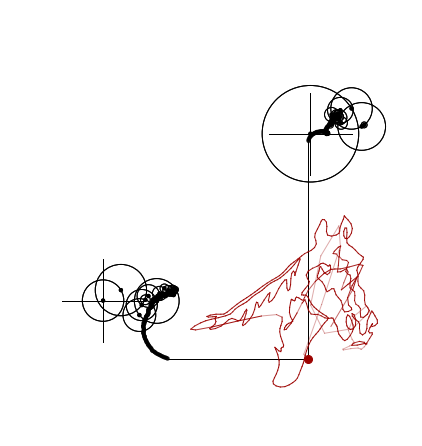

In [20]:
xCircles = ComplexCircles(xFT, num_circles=num_circles, origin=x_origin)
yCircles = ComplexCircles(yFT, num_circles=num_circles, origin=y_origin)

#------------------------------------------------------------
# set up figure and styling
fig = plt.figure()
plt.axis([-400,75,-150,350])

ax = plt.gca()
ax.set_aspect(1)
ax.set_facecolor('#f9f9f9')

# Suppress axes
ax.set_yticklabels([])
#ax.set_xticklabels([])
plt.tight_layout(pad=0)
plt.axis('off')

circle_color = 'black'
drawing_color = '#9c0200'


#------------------------------------------------------------
# Set up animation elements


# INITIALIZE CIRLCE PLOTS
alphas = np.linspace(1, 0.25, num_circles) #np.repeat(1, num_circles)
X_circle_objs = []
X_center_objs = []
Y_circle_objs = []
Y_center_objs = []

X_radii, X_x_centers, X_y_centers, X_x_final, X_y_final = xCircles.get_circles()
Y_radii, Y_x_centers, Y_y_centers, Y_x_final, Y_y_final = yCircles.get_circles(transpose=True)


for c in range(0,num_circles):
    # X Outer Circles
    Xcirc = plt.Circle((X_x_centers[c], X_y_centers[c]), radius=X_radii[c],
                      edgecolor=circle_color, facecolor='None', alpha=alphas[c])
    X_circle_objs.append(Xcirc)
    # X Center Point Circles
    Xcenter = plt.Circle((X_x_centers[c], X_y_centers[c]), radius=2,
                      edgecolor=circle_color, facecolor=circle_color, alpha=alphas[c])
    X_center_objs.append(Xcenter)
    
    
    # Y Outer Circles
    Ycirc = plt.Circle((Y_x_centers[c], Y_y_centers[c]), radius=Y_radii[c],
                      edgecolor=circle_color, facecolor='None', alpha=alphas[c])
    Y_circle_objs.append(Ycirc)
    # Y Center Point Circles
    Ycenter = plt.Circle((Y_x_centers[c], Y_y_centers[c]), radius=2,
                      edgecolor=circle_color, facecolor=circle_color, alpha=alphas[c])
    Y_center_objs.append(Ycenter)

    
# Connectors between end of circles and actual drawing
X_connector_line, = ax.plot([], [], '-', lw=1, color='black')
Y_connector_line, = ax.plot([], [], '-', lw=1, color='black') 

# Point on plot at current time t
trace_point, = ax.plot([], [], 'o', markersize=8, color=drawing_color)

# Trace of full drawing
drawing_segments = []
for idx in range(len(xFT.t_vals)):
    segment, = ax.plot([-1000, -1001], [-1000,-1001], '-', lw=1, color=drawing_color, alpha=alpha_vals[idx])
    drawing_segments.append(segment)
# Add one more for line segment
segment, = ax.plot([-1000,-1001], [-1000,-1001], '-', lw=1, color=drawing_color, alpha=alpha_vals[0])
drawing_segments.append(segment)


# Plot axes of cirlces
x_main_offset = X_x_centers[0]
y_main_offset = Y_y_centers[0]

axis_length = 50
axis_style = {
    "linestyle": "solid",
    "linewidth": 1,
    "color": "black"
}
x_x_axis = ax.plot(
    [x_main_offset-axis_length, x_main_offset+axis_length], 
    [X_circles_spacing,X_circles_spacing],
    **axis_style
)
x_y_axis = ax.plot(
    [x_main_offset, x_main_offset], 
    [X_circles_spacing-axis_length,X_circles_spacing+axis_length],
    **axis_style
)
y_x_axis = ax.plot(
    [-Y_circles_spacing-axis_length, -Y_circles_spacing+axis_length],
    [y_main_offset, y_main_offset], 
    **axis_style
)
y_y_axis = ax.plot(
    [-Y_circles_spacing, -Y_circles_spacing],
    [y_main_offset-axis_length, y_main_offset+axis_length], 
    **axis_style
)


def init():
    """initialize animation"""
    for idx in range(len(xFT.t_vals)):
        drawing_segments[idx].set_data([],[])
    
    X_connector_line.set_data([], [])
    Y_connector_line.set_data([], [])
    trace_point.set_data([], [])
    #centers.set_data([], [])
    for c in range(num_circles):
        ax.add_patch(X_circle_objs[c])
        ax.add_patch(X_center_objs[c])
        ax.add_patch(Y_circle_objs[c])
        ax.add_patch(Y_center_objs[c])
    return([])

def animate(i):
    """perform animation step"""
        
    X_radii, X_x_centers, X_y_centers, X_x_final, X_y_final = xCircles.get_circles()
    Y_radii, Y_x_centers, Y_y_centers, Y_x_final, Y_y_final = yCircles.get_circles(transpose=True)
    #Y_x_centers = [x - circles_spacing for x in Y_x_centers]
    #Y_x_final = Y_x_final - circles_spacing

    
    for c in range(0,num_circles):
        # X Outer Circles
        X_circle_objs[c].center = (X_x_centers[c], X_y_centers[c])
        # X Center Point Circles
        X_center_objs[c].center = (X_x_centers[c], X_y_centers[c])

        # Y Outer Circles
        Y_circle_objs[c].center = (Y_x_centers[c], Y_y_centers[c])
        # Y Center Point Circles
        Y_center_objs[c].center = (Y_x_centers[c], Y_y_centers[c])
        
    
    #idx_current = max(int(np.round(xCircles.t_current)),len(xFT.fourier_approximation)-1)
    idx_current = xCircles.t_index_current
    x_true_current = deepcopy(xCircles.fourier_approx_val_current)
    y_true_current = deepcopy(yCircles.fourier_approx_val_current)
    X_connector_line.set_data(
        [x_true_current, x_true_current], 
        [y_true_current, X_y_final]
    )
    Y_connector_line.set_data(
        [Y_x_final, x_true_current], [y_true_current, y_true_current]
    )
    trace_point.set_data([x_true_current], [y_true_current])
    
    # Iterate circles to next step
    xCircles.step(dt=dt)
    yCircles.step(dt=dt)

    drawing_segments[idx_current].set_data(
        [x_true_current, xCircles.fourier_approx_val_current], 
        [y_true_current, yCircles.fourier_approx_val_current]
    )

    
    return([])


 


ani = animation.FuncAnimation(fig, animate, frames=num_frames,
                              interval=interval, blit=True, init_func=init)

HTML(ani.to_html5_video())

In [71]:
# Fun miscellaneous function to draw a single frame of the 
# circles animation; understanding this step and getting the
# phase/amplitude of the circles correct is 90% of the work
# for understanding how the full animation works
def draw_circles(FT, t, num_circles=200):
    
    period = FT.period
    As = FT.amplitudes[0:num_circles]
    Zs = FT.phases[0:num_circles]

    t_vals = np.linspace(0,3000, 500)
    Xs = []
    Ys = []
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    x_offset = 0
    y_offset = 0

    col="#004785"
    
    for i in range(0,num_circles):
        Hz = i+1
        a = As[i] # Magnitude (i.e., amplitude) of complex coefficient
        z = Zs[i] # Argument (i.e., phase) of complex coefficient

        plt.plot([x_offset], [y_offset], marker='o', markersize=10, color=col)
        circ = plt.Circle((x_offset, y_offset), radius=2*a, edgecolor='black',
                          linewidth=2, facecolor='None')
        ax.add_patch(circ)

        x_offset += 2*a*np.cos(t*2*np.pi*Hz/period + z)
        y_offset += 2*a*np.sin(t*2*np.pi*Hz/period + z)

    Xs.append(x_offset)
    Ys.append(y_offset)
    plt.axis('equal')
    plt.show()
    return(fig)

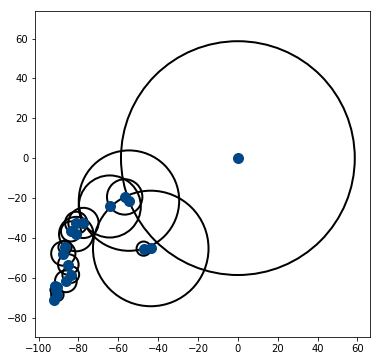

In [73]:
f = draw_circles(xFT, 1400, num_circles=20)